## Imports

In [5]:
from typing import List, Set, Tuple, Union, Optional
from pathlib import Path
import ast

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd

from divemt.qe_taggers import NameTBDGeneralTags, NameTBDTagger
from divemt.qe_taggers.custom_simalign import SentenceAligner as CustomSentenceAligner

## Load data

In [6]:
DATASET_FOLDER = Path() / '..' / 'data' / 'processed'
DATASET_FOLDER.exists()

True

In [ ]:
def get_sample(df, idx):
    sample = df.iloc[idx]
    lang_id = sample['lang_id']

    src_tokens = ast.literal_eval(sample['src_tokens'])
    mt_tokens = ast.literal_eval(sample['mt_tokens'])
    tgt_tokens = ast.literal_eval(sample['tgt_tokens'])

    src_tbd_qe = ast.literal_eval(sample[f'src_tbd_qe'])
    mt_tbd_qe = ast.literal_eval(sample[f'mt_tbd_qe'])

    return lang_id, src_tokens, mt_tokens, tgt_tokens, src_tbd_qe, mt_tbd_qe

In [ ]:
# read pandas dataframe
df_it = pd.read_csv(DATASET_FOLDER / 'ita' / 't1_warmup_texts.tsv', sep='\t')
df_it = df_it[pd.notna(df_it['mt_tokens'])]
len(df_it)
df_it

## Aux functions for visualization

In [7]:
def custom_bipartite_layout(
    G, top, bottom, aspect_ratio=4 / 3,
):
    height = 1
    width = aspect_ratio * height
    offset = (width / 2, height / 2)

    nodes = list(top) + bottom

    left_xs = np.repeat(0, len(top))
    right_xs = np.repeat(width, len(bottom))
    left_ys = np.linspace(0, height, len(top))
    right_ys = np.linspace(0, height, len(bottom))

    top_pos = np.column_stack([left_xs, left_ys]) - offset
    bottom_pos = np.column_stack([right_xs, right_ys]) - offset

    pos = np.concatenate([top_pos, bottom_pos])
    pos = pos[:, ::-1]  # swap x and y coords for horizontal
    pos = dict(zip(nodes, pos))
    return pos


In [8]:
def draw_aligned_qe(
        top_tokens: List[str],
        bottom_tokens: List[str],
        top_qe_tags: Optional[List[Union[str, Set[str]]]],
        bottom_qe_tags: Optional[List[Union[str, Set[str]]]],
        top_bottom_alignments: List[Union[Tuple[int, int], Tuple[int, int, float]]],
        *,
        title: str = None,
):
    # create graph
    G = nx.Graph()
    top, bottom = [f'top_{i}' for i in range(len(top_tokens))], [f'bottom_{i}' for i in range(len(bottom_tokens))]
    G.add_nodes_from(top, bipartite=0)
    G.add_nodes_from(bottom, bipartite=1)
    G.add_edges_from([(f'top_{alignment[0]}', f'bottom_{alignment[1]}') for alignment in top_bottom_alignments])

    # set words as nore names
    custom_node_names = {}
    custom_node_names.update({f'top_{i}': tok for i, tok in enumerate(top_tokens)})
    custom_node_names.update({f'bottom_{i}': tok for i, tok in enumerate(bottom_tokens)})

    # set qe attributes as labels
    custom_node_attrs = {}
    if top_qe_tags:
        custom_node_attrs.update({f'top_{i}': str(qe) for i, qe in enumerate(top_qe_tags)})
    if bottom_qe_tags:
        custom_node_attrs.update({f'bottom_{i}': str(qe) for i, qe in enumerate(bottom_qe_tags)})

    # connection weighs if any
    if top_bottom_alignments and len(top_bottom_alignments[0]) == 3:
        custom_edge_weights = {(f'top_{i}', f'bottom_{j}'): round(w, 2) for i, j, w in top_bottom_alignments}
    else:
        custom_edge_weights = None

    # get nodes and attributes positions
    pos = custom_bipartite_layout(G, bottom, top)
    pos_attrs = {node: (x, y+0.2) if node in top else (x, y-0.2) for node, (x, y) in pos.items()}

    # draw graph
    fig, ax = plt.subplots()
    width = max(3*max(len(top_tokens), len(bottom_tokens)), 12)
    ax.margins(0.1, 0.2)
    height = 6
    fig.set_size_inches(width, height)
    nx.draw_networkx(G, pos=pos, width=2, ax=ax, labels=custom_node_names, node_size=0, bbox=dict(facecolor='white', edgecolor='skyblue', boxstyle='round', pad=0.2), edgelist=custom_edge_weights.keys(), edge_color=custom_edge_weights.values(), edge_cmap=plt.cm.Blues, edge_vmin=0.5, edge_vmax=1)
    nx.draw_networkx_labels(G, pos_attrs, labels=custom_node_attrs, font_size=9)
    if custom_edge_weights:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=custom_edge_weights, font_size=8, label_pos=0.5, ax=ax)
    if title:
        ax.set_title(title)
    plt.show()

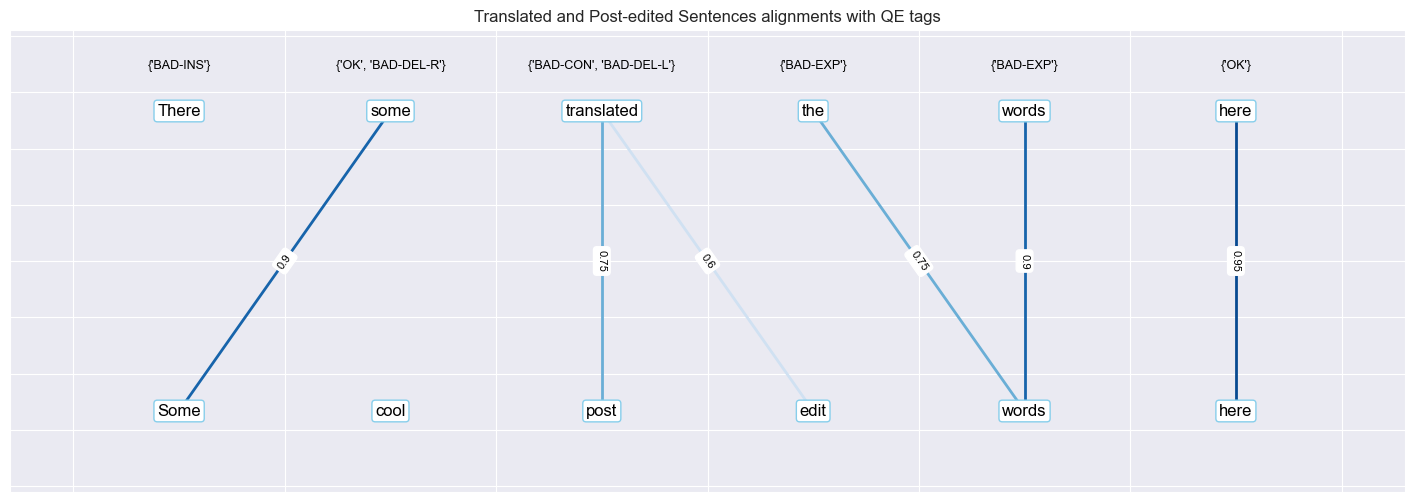

In [16]:
alignments = [(1, 0, 0.9), (2, 2, 0.75), (2, 3, 0.6), (3, 4, 0.75), (4, 4, 0.9), (5, 5, 0.95)]
top_tokens = ['There', 'some', 'translated', 'the', 'words', 'here']
top_qe = [{'BAD-INS'}, {'OK', 'BAD-DEL-R'}, {'BAD-CON', 'BAD-DEL-L'}, {'BAD-EXP'}, {'BAD-EXP'}, {'OK'}]
bottom_tokens = ['Some', 'cool', 'post', 'edit', 'words', 'here']
# bottom_qe = [{'OK'}, {'BAD-INS'}, {'BAD-DEL-L', 'OK'}, {'BAD-DEL-R', 'OK'}]
bottom_qe = []

draw_aligned_qe(top_tokens, bottom_tokens, top_qe, bottom_qe, alignments, title='Translated and Post-edited Sentences alignments with QE tags')

## Load align models

In [6]:
aligner_bert = CustomSentenceAligner(model="bert", token_type="bpe", matching_methods="mai", return_similarity="avg")
aligner_xlmr = CustomSentenceAligner(model="xlmr", token_type="bpe", matching_methods="mai", return_similarity="avg")
tagger_bert = NameTBDTagger(aligner=aligner_bert)
tagger_xlmr = NameTBDTagger(aligner=aligner_xlmr)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.b

## Cherry pick samples and analyze alignments

In [45]:
# select index of a sample to visualize
idx = 1
# idx = 5
# idx = 8
# idx = 10
lang_id, src_tokens, mt_tokens, tgt_tokens, src_tbd_qe, mt_tbd_qe = get_sample(df_it, idx)

xlmr

Aligning mt-pe: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


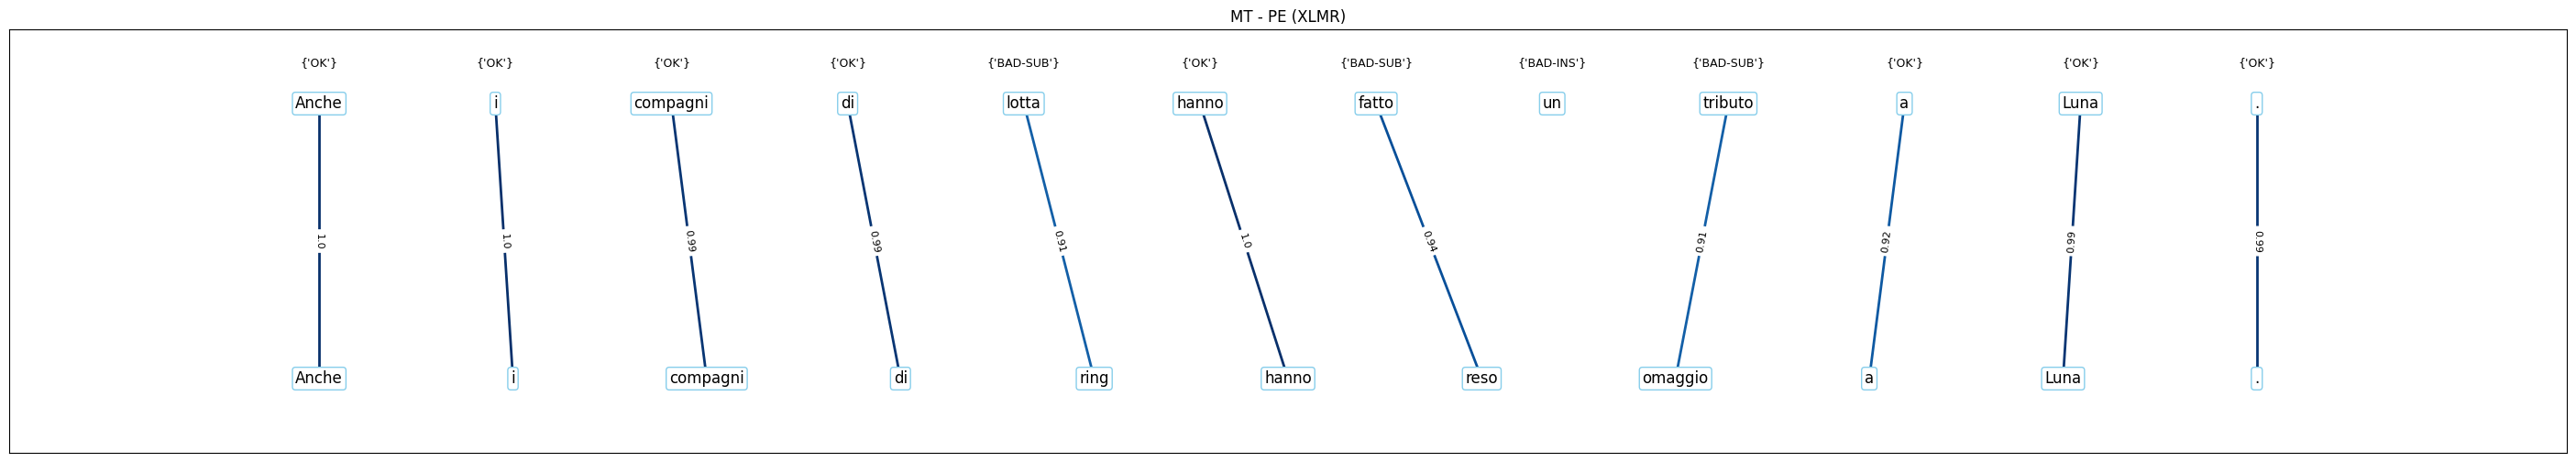

In [46]:
mt_pe_alignments = tagger_xlmr.align_mt_pe([mt_tokens], [tgt_tokens], lang_id)[0]
draw_aligned_qe(mt_tokens, tgt_tokens, mt_tbd_qe, None, mt_pe_alignments, title='MT - PE (XLMR)')

Aligning src-mt: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


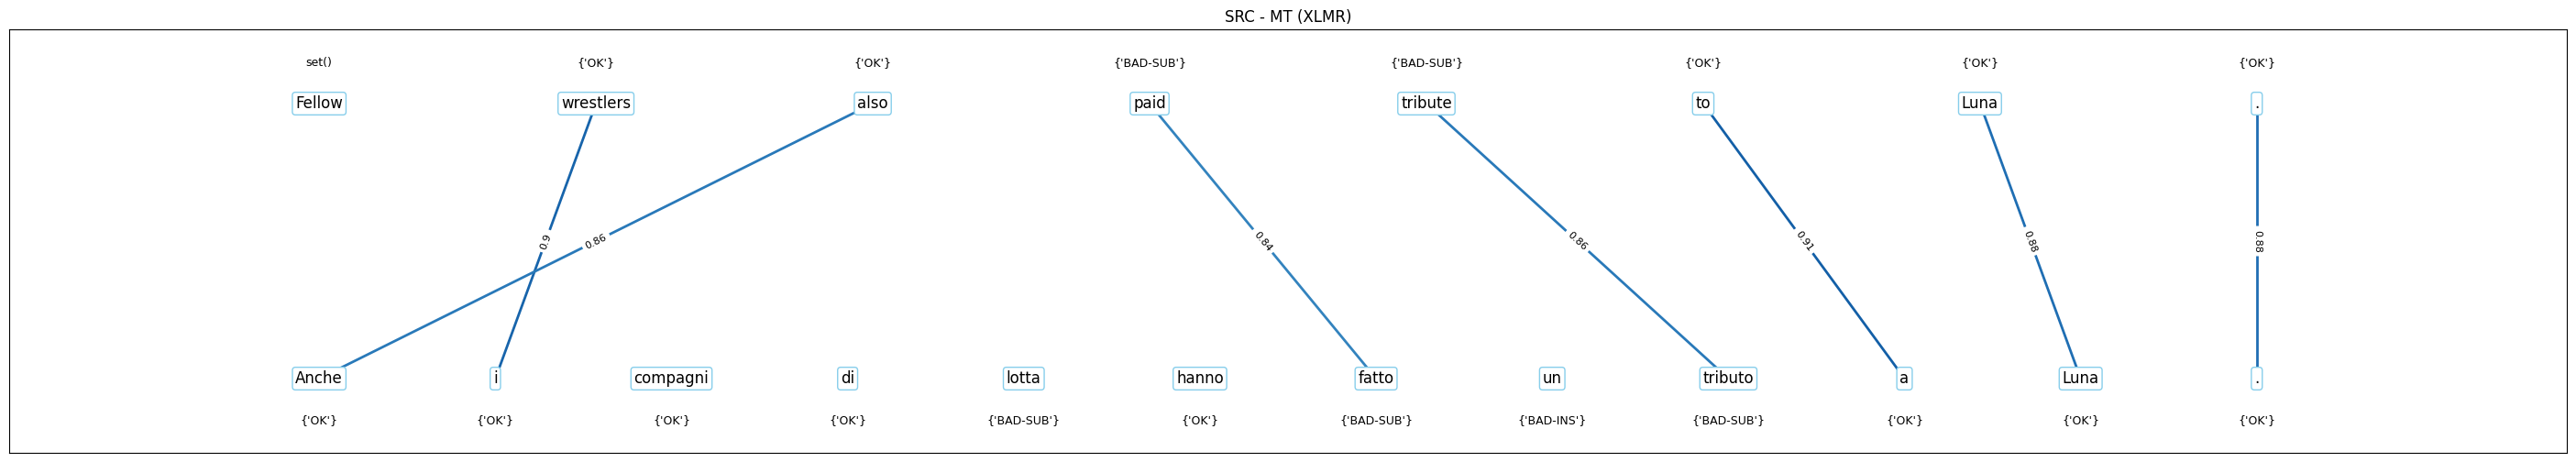

In [47]:
src_mt_alignments = tagger_xlmr.align_source_mt([src_tokens], [mt_tokens], 'eng', lang_id)[0]
draw_aligned_qe(src_tokens, mt_tokens, src_tbd_qe, mt_tbd_qe, src_mt_alignments, title='SRC - MT (XLMR)')

bert

Aligning mt-pe: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


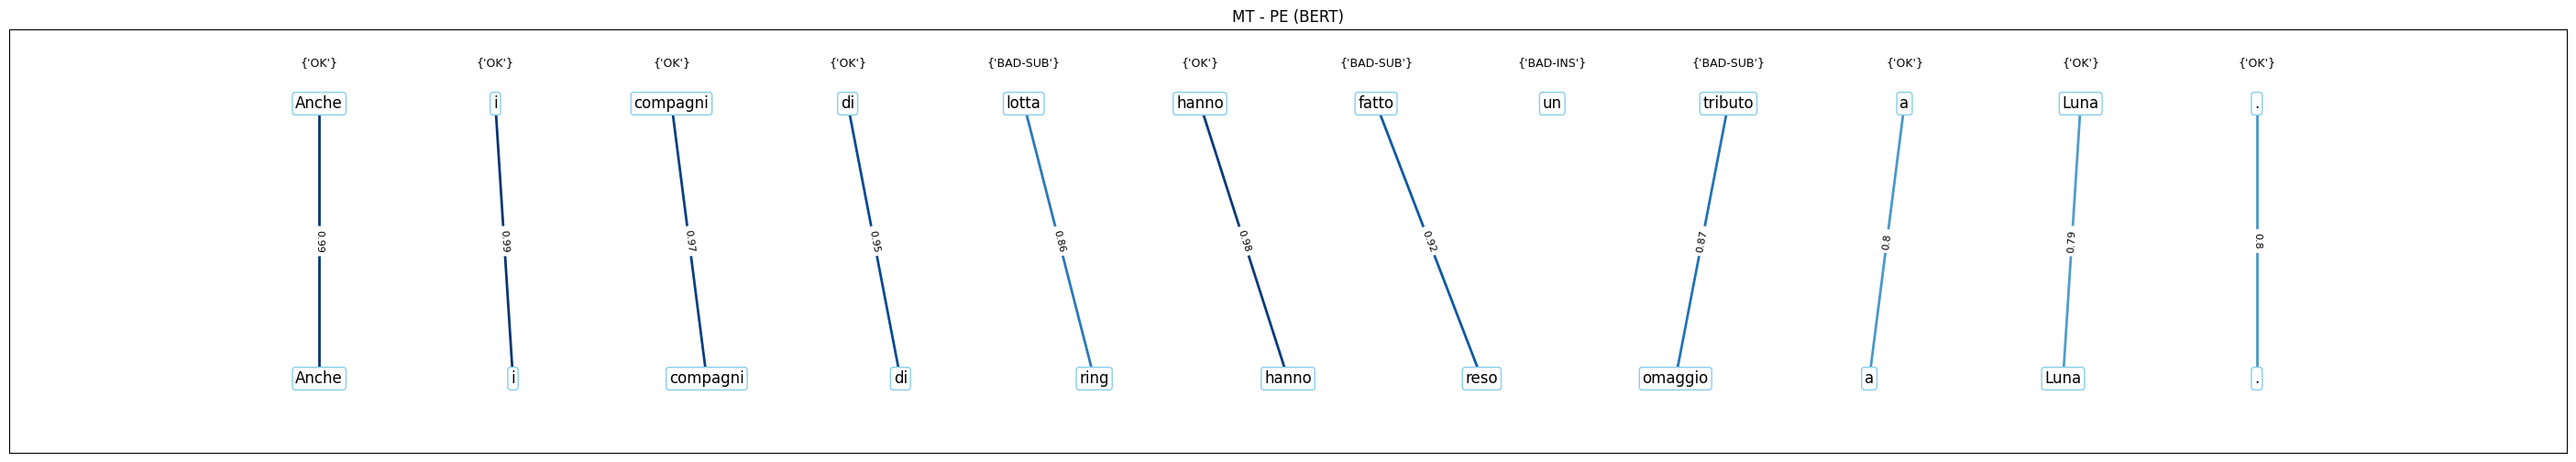

In [48]:
mt_pe_alignments = tagger_bert.align_mt_pe([mt_tokens], [tgt_tokens], lang_id)[0]
draw_aligned_qe(mt_tokens, tgt_tokens, mt_tbd_qe, None, mt_pe_alignments, title='MT - PE (BERT)')

Aligning src-mt: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


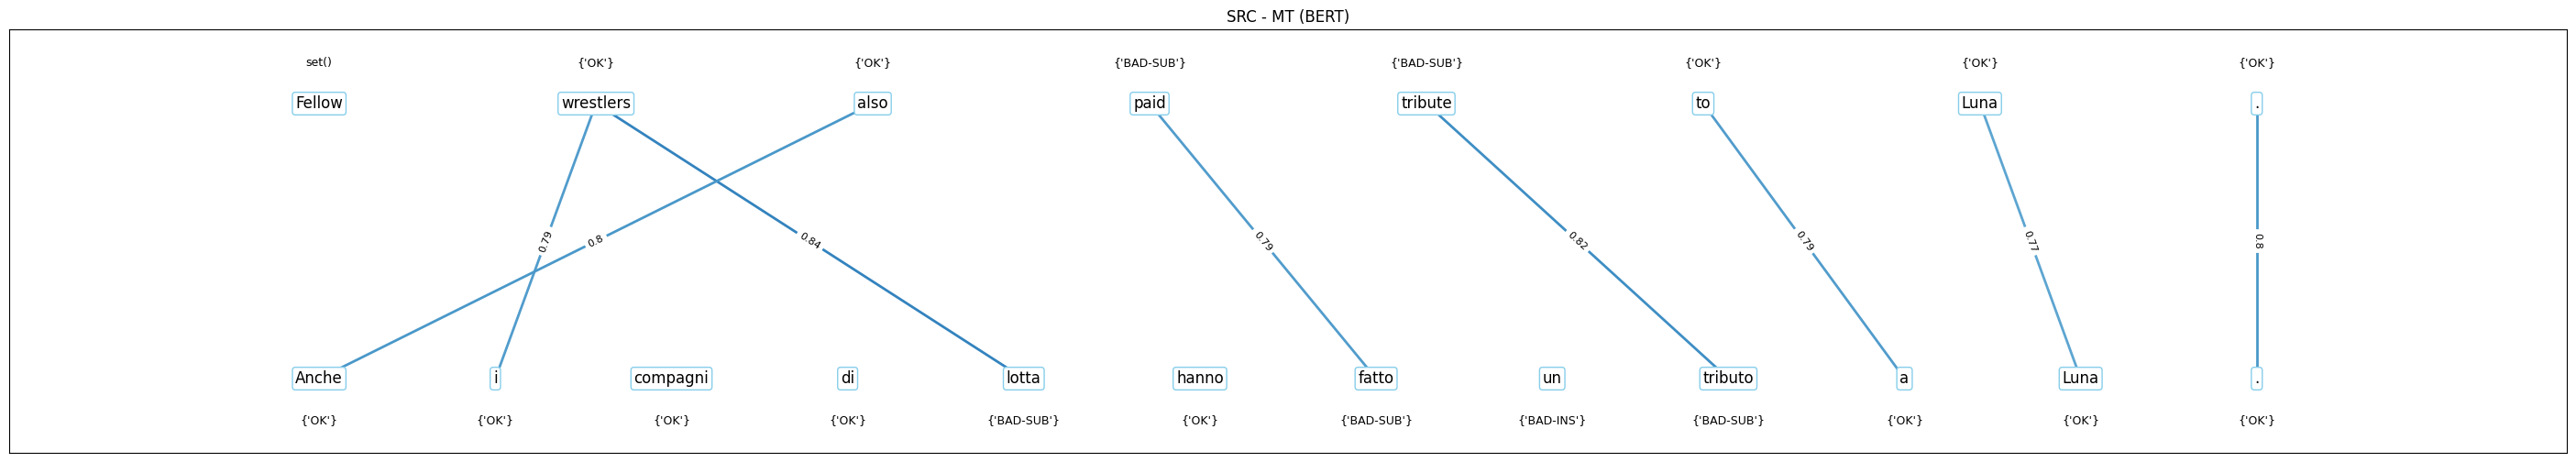

In [49]:
src_mt_alignments = tagger_bert.align_source_mt([src_tokens], [mt_tokens], 'eng', lang_id)[0]
draw_aligned_qe(src_tokens, mt_tokens, src_tbd_qe, mt_tbd_qe, src_mt_alignments, title='SRC - MT (BERT)')